In [14]:
from vmap_utils import PEPS_Model
import quimb.tensor as qtn
import quimb as qu
import pickle
import torch

Lx = 4
Ly = 2
D = 4
chi = D
pwd = '/home/sijingdu/TNVMC/VMC_code/vmc_torch/vmc_torch/experiment/vmap'
skeleton = pickle.load(open(pwd+f'/{Lx}x{Ly}/heis/D={D}/peps_skeleton.pkl', 'rb'))
params = pickle.load(open(pwd+f'/{Lx}x{Ly}/heis/D={D}/peps_su_params.pkl', 'rb'))
peps = qtn.unpack(params, skeleton)

model = PEPS_Model(tn=peps, max_bond=chi)

B = 10
random_binary_config = torch.randint(0, 2, (B, Lx*Ly)).int()

model(random_binary_config)

tensor([-1.6680e-04,  2.4504e-01, -4.8052e-02,  2.4441e-02, -7.5758e-02,
        -4.8052e-02,  2.4504e-01,  2.6053e-02, -5.6787e-04,  4.2785e-02],
       dtype=torch.float64, grad_fn=<MulBackward0>)

In [15]:
qtn.ham_2d_heis(Lx, Ly, j=1)

<LocalHam2D(Lx=4, Ly=2, num_terms=10)>

In [16]:
from SPIN_models import circuit_TNF_2d_Model  # NOTE: add vamp func to all models to allow vmap evaluation

circuit_model = circuit_TNF_2d_Model(
    tns=peps,
    ham=qtn.ham_2d_heis(Lx, Ly, j=1),
    trotter_tau=0.1,
    depth=2,
    max_bond=16,
    dtype=torch.float64,
    from_which="zmax",
    mode="SVDU",
)

circuit_model(random_binary_config)
# params = qu.utils.tree_unflatten(circuit_model.params, circuit_model.params_pytree)
# for _ in range(B):
#     print(circuit_model.amplitude(random_binary_config[0], params))
nparams = 0
for p in circuit_model.parameters():
    nparams += p.numel()
print(nparams)

1120


In [17]:
depth = 2
ham=qtn.ham_2d_heis(Lx, Ly, j=1)
circuit_tnf = circuit_model.form_gated_tns_tnf(tns=peps, ham=ham, tau=0.1, depth=depth, contract_layer=False, gate_contract=False)
x = random_binary_config[0]
amp = circuit_tnf.isel({ind: x[i] for i, ind in enumerate(circuit_model.site_inds)})

In [29]:
tau = 0.1
peps0 = peps.copy()
for where in ham.get_auto_ordering():
    gate = ham.get_gate_expm(where, -1 * tau)
    site_inds = [peps0.site_ind_id.format(*site) for site in where]
    extra_tags = ["ROUND_{}".format(0 + 1), where]
    ltag = peps0.site_tag_id.format(*where[0])
    rtag = peps0.site_tag_id.format(*where[1])
    peps0 = peps0.gate_inds(
        gate,
        inds=site_inds,
        contract=False,
        tags=extra_tags,
        ltags=ltag,
        rtags=rtag,
    )
shape = peps0.tensors[-1].data.shape
peps0.tensors[-1].data, ham.get_gate_expm(where, -1 * tau).reshape(shape)


(array([[[[ 0.97530991,  0.        ],
          [ 0.        ,  0.        ]],
 
         [[ 0.        ,  1.02659703],
          [-0.05128712,  0.        ]]],
 
 
        [[[ 0.        , -0.05128712],
          [ 1.02659703,  0.        ]],
 
         [[ 0.        ,  0.        ],
          [ 0.        ,  0.97530991]]]]),
 array([[[[ 0.97530991,  0.        ],
          [ 0.        ,  0.        ]],
 
         [[ 0.        ,  1.02659703],
          [-0.05128712,  0.        ]]],
 
 
        [[[ 0.        , -0.05128712],
          [ 1.02659703,  0.        ]],
 
         [[ 0.        ,  0.        ],
          [ 0.        ,  0.97530991]]]]))

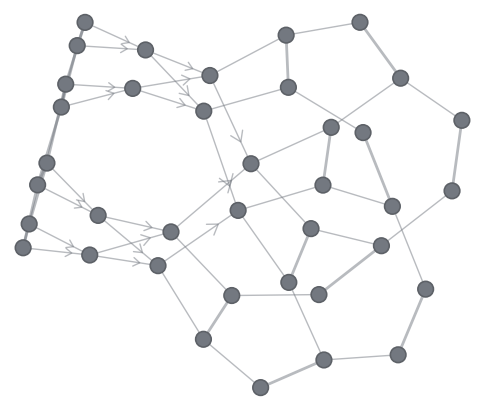

In [6]:
amp.draw()

In [7]:
amp

PEPS(tensors=38, indices=60, Lx=4, Ly=2, max_bond=4)

In [8]:
from quimb.tensor.tensor_core import tags_to_oset, group_inds
amp_copy = amp.copy()
for site in amp_copy.sites:
    amp_copy.contract_tags_(
        [amp_copy.site_tag_id.format(*site), f"ROUND_{depth}"],
        inplace=True,
        which="all",
    )
main_tnf, inverse_peps = amp_copy.partition(f'ROUND_{depth}', inplace=True)
gates_tn, init_peps = main_tnf.partition(f'ROUND_{0}', inplace=True)
init_outer_inds = qtn.bonds(gates_tn, init_peps)
init_peps.reindex_(dict(zip(init_outer_inds, circuit_model.site_inds)))

inverse_peps.outer_inds(), inverse_peps.tensors
outer_inds = inverse_peps.outer_inds()
inverse_peps.reindex_({outer_inds[i]: circuit_model.site_inds[i] for i in range(len(outer_inds))})
main_tnf.reindex_({outer_inds[i]: circuit_model.site_inds[i] for i in range(len(outer_inds))})
inverse_peps.view_as_(qtn.PEPS)
nn_where_list = circuit_model.ham.get_auto_ordering()
for d in range(depth-1, 0, -1):
    for where in nn_where_list[::-1]:
        (tid,) = gates_tn._get_tids_from_tags([f'ROUND_{d}', where])
        gate = gates_tn.pop_tensor(tid)
        pinds = [inverse_peps.site_ind_id.format(*site) for site in where]
        gate_inds_outer = [ind for ind in gate.inds if ind not in pinds]
        (tid1,), (tid2,) = inverse_peps._get_tids_from_inds(pinds[0]), inverse_peps._get_tids_from_inds(pinds[1])

        temp_tags = tags_to_oset(['gate-temp'])
        inverse_peps.tensor_map[tid1].modify(tags = inverse_peps.tensor_map[tid1].tags | temp_tags)
        inverse_peps.tensor_map[tid2].modify(tags = inverse_peps.tensor_map[tid2].tags | temp_tags)
        tl, tr = inverse_peps._inds_get(pinds[0], pinds[1])
        bnds_l, (bix,), bnds_r = group_inds(tl, tr)

        gate.modify(tags = gate.tags | temp_tags)

        inverse_peps.gate_inds_with_tn_(inds=pinds, gate=gate, gate_inds_inner=pinds, gate_inds_outer=gate_inds_outer)
        gates_tn.reindex_(dict(zip(gate_inds_outer, pinds)))
        # inverse_peps.draw('gate-temp')
        inverse_peps.contract_tags_(temp_tags)
        (contracted_ts_tid,) = inverse_peps._get_tids_from_tags(temp_tags)
        

        contracted_ts = inverse_peps.pop_tensor(contracted_ts_tid)
        tln, *maybe_svals, trn = contracted_ts.split(
            left_inds=bnds_l,
            right_inds=bnds_r,
            bond_ind=bix,
            get="tensors",
            max_bond=chi,
            cutoff=0.0,
            absorb='left'
        )
        # remove temp tags
        tln.tags.remove('gate-temp')
        trn.tags.remove('gate-temp')
        inverse_peps = (inverse_peps | tln | trn)
        inverse_peps.view_like_(amp_copy)
        

(init_peps | inverse_peps).contract(), amp.contract()

(np.float64(0.0016144775168085244), np.float64(0.0017234988020003597))